In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import yaml
from scipy.interpolate import interp1d
from scipy import integrate
import pickle

# This splits finds the root directory by splitting until we have gotten to what is under Cryogenic Material Properties
root_dir = os.path.abspath("Interpolation.ipynb")
while os.path.split(root_dir)[1] != "Cryogenic_Material_Properties":
    root_dir = os.path.split(root_dir)[0]
root_dir = os.path.split(root_dir)[0]

# We want the directory in our path to import tc tools
cm_dir = f"{root_dir}{os.sep}Cryogenic_Material_Properties"

if cm_dir not in sys.path:
    sys.path.append(cm_dir)

from thermal_conductivity.tc_tools import *
from thermal_conductivity.tc_plots import plot_all_fits

In [32]:
def interpolate(material, preferred_fit = None):
    material_folder = f"{cm_dir}{os.sep}thermal_conductivity{os.sep}lib{os.sep}{material}"

    # Let's search to see if the material has room temperature data so we can include that in our interpolation
    room_temperature_data = False
    config_path = f"{material_folder}{os.sep}room_temperature.yaml"
    if os.path.exists(config_path):
        with open(config_path, 'r') as file:
            config = yaml.safe_load(file)
        room_temperature_data = True
        room_temp = float(config['room_temperature_conductivity'][0])
        room_k = float(config['room_temperature_conductivity'][1])

    # Loading all fit data for the material in question
    fits = np.loadtxt(f"{material_folder}{os.sep}all_fits.csv", dtype = str, delimiter = ',')
    num_fits = len(fits) - 1

    # This creates a list of each fit's low and high temperature bounds
    low_temps = fits[1:, 2]
    low_temps = [float(i) for i in low_temps]
    high_temps = fits[1:, 3]
    high_temps = [float(i) for i in high_temps]

    # We want to sort our fits to go in numerical order by low temperature range 
    # This will make it easy to choose when to switch fits during interpolation
    sorting_indices = np.argsort(low_temps)
    low_temps = np.array(low_temps)[sorting_indices]
    high_temps = np.array(high_temps)[sorting_indices]
    sorting_indices = np.append(0, sorting_indices + 1)
    sorted_fits = fits[sorting_indices, :]
    fit_names = sorted_fits[1:, 0]

    Ts = np.empty(0, float)
    ks = np.empty(0, float)

    # If we have a fit we prefer the interpolation to use, it will create the points here and block other fits from overriding them later
    if preferred_fit != None:
        preferred_fit = str(preferred_fit)
        parameters = get_parameters(sorted_fits, preferred_fit)
        func_type = get_func_type(parameters['fit_type'])
        preferred_fit_range = parameters['fit_range']
        T = np.logspace(np.log10(preferred_fit_range[0]), np.log10(preferred_fit_range[1]), 1000)
        k = func_type(T, parameters)
        Ts = np.append(Ts, T)
        ks = np.append(ks, k)

    # Here, we go through every fit for the chosen material and decide what parts of each fit to use
    for i in range(num_fits):
        # We don't want to use a fit whose temperature range is contained inside the last fit we used
        if i != 0 and high_temps[i] <= high_temps[i - 1]:
            continue
        # We want to reduce the list of fits just to the one in question because tc tools can get confused if two fits are both named "raw_fit" for example
        current_fit = sorted_fits[[0, i + 1], :]
        parameters = get_parameters(current_fit, fit_names[i])
        func_type = get_func_type(parameters['fit_type'])
        fit_range = parameters['fit_range']
        # If two fits intersect at the temperature ranges, we want it to switch from one to the other so it does not oscillate between the two
        if i != 0 and low_temps[i] < high_temps[i - 1]:
            fit_range[0] = high_temps[i - 1]
        T = np.logspace(np.log10(fit_range[0]), np.log10(fit_range[1]), 1000)
        # Here we remove any points that intersect with our preferred fit
        if preferred_fit != None:
            indices = np.where((T < preferred_fit_range[0]) | (T > preferred_fit_range[1]))
            T = T[indices]
        # Here we generate our conductivity points to feed to the interpolation
        # Some fits don't function the same as others and are not currently supported
        try:
            k = func_type(T, parameters)
        except:
            print(f"{func_type} not supported.")
            k = [0 for i in T]

        Ts = np.append(Ts, T)
        ks = np.append(ks, k)

    if room_temperature_data:
        Ts = np.append(Ts, room_temp)
        ks = np.append(ks, room_k)
        
    return interp1d(Ts, ks)

In [29]:
def plot_interpolation(material, interpolation_function, show = False):
    material_folder = f"{cm_dir}{os.sep}thermal_conductivity{os.sep}lib{os.sep}{material}"

    # Let's search to see if the material has room temperature data so we can include that in our interpolation
    room_temperature_data = False
    config_path = f"{material_folder}{os.sep}room_temperature.yaml"
    if os.path.exists(config_path):
        with open(config_path, 'r') as file:
            config = yaml.safe_load(file)
        room_temperature_data = True
        room_temp = float(config['room_temperature_conductivity'][0])
        room_k = float(config['room_temperature_conductivity'][1])

    # Generating plot assets and loading all fit data for the material in question
    fig, ax = plt.subplots()
    fits = np.loadtxt(f"{material_folder}{os.sep}all_fits.csv", dtype = str, delimiter = ',')

    # This creates a list of each fit's low and high temperature bounds
    low_temps = fits[1:, 2]
    low_temps = [float(i) for i in low_temps]
    high_temps = fits[1:, 3]
    high_temps = [float(i) for i in high_temps]

    # Finding the range of the interpolation function
    T_range = [min(low_temps), max(high_temps)]
    print(type(room_temp))
    if room_temperature_data:
        T_range = [min(low_temps), max(*high_temps, room_temp)]
        plt.plot(room_temp, room_k, '.', label = f"{room_temp} Kelvin conductivity")
    T = np.logspace(np.log10(T_range[0]), np.log10(T_range[1]), 1000)
    # Due to floating point error, we may want to redefine the final temperature point
    # I was recieving an error that 300.00000001 was out of the interpolation's range
    if room_temperature_data and T_range[1] == room_temp:
        T[-1] = room_temp
    # Here, we are generating the interpolation's conductivity points to plot 
    k = interpolation_function(T)

    # Finally, let's plot all the curves
    plt.plot(T, k, label = "interpolation")
    plot_all_fits(fits, material, material_folder, save = False, show = False)
    # If our room temperature data is out of bounds of the fits, we may want to shift the plot limits
    if room_temperature_data:
        plt.xlim(T_range[0], T_range[1])
        k_range = ax.get_ylim()
        plt.ylim(k_range[0], max(k_range[1], room_k))
    if show:
        plt.show()
        plt.clf()

In [12]:
def update_interpolation(material, preferred_fit = None):
    # Creating the interpolation
    interpolation = interpolate(material, preferred_fit)

    # Creating a pickle file with the interpolation function for the material in question
    material_folder = f"{cm_dir}{os.sep}thermal_conductivity{os.sep}lib{os.sep}{material}"
    with open(f'{material_folder}{os.sep}interpolation.pkl', 'wb') as file:
        pickle.dump(interpolation, file)

    # Creating plots for to view the interpolation curve
    plot_interpolation(material, interpolation)
    plt.savefig(f"{material_folder}{os.sep}plots{os.sep}{material}_interpolation.png", dpi=300) 
    plt.savefig(f"{material_folder}{os.sep}plots{os.sep}{material}_interpolation.pdf", dpi=300) 

First, let's generate a plot of our interpolation to see that it works.

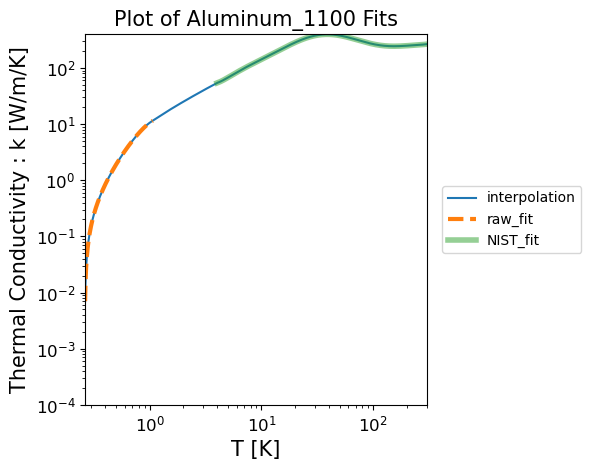

<Figure size 640x480 with 0 Axes>

In [13]:
material = "Aluminum_1100"
Al_1100_interpolation = interpolate(material)
plot_interpolation(material, Al_1100_interpolation, show = True)

Nice! Now let's test if we can export/import the interpolation function in a pickle file.

In [14]:
with open(f'{cm_dir}{os.sep}thermal_conductivity{os.sep}interpolation_test.pkl', 'wb') as file:
    pickle.dump(Al_1100_interpolation, file)

In [15]:
with open(f'{cm_dir}{os.sep}thermal_conductivity{os.sep}interpolation_test.pkl', 'rb') as file:
    loaded_Al_1100_interpolation = pickle.load(file)

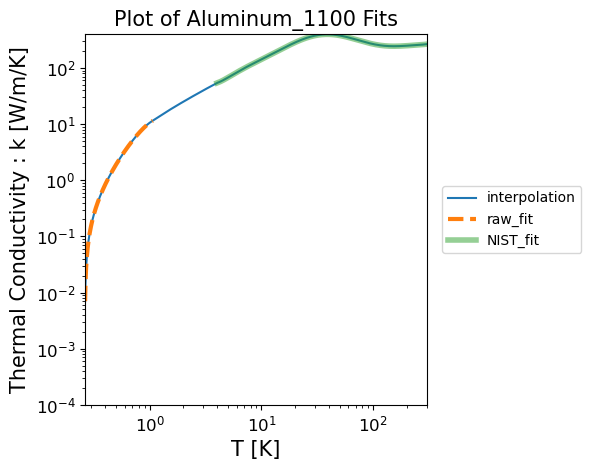

<Figure size 640x480 with 0 Axes>

In [16]:
material = "Aluminum_1100"
plot_interpolation(material, loaded_Al_1100_interpolation, show = True)

Awesome! Now let's see that it behaves properly when encountering conflicting curves.

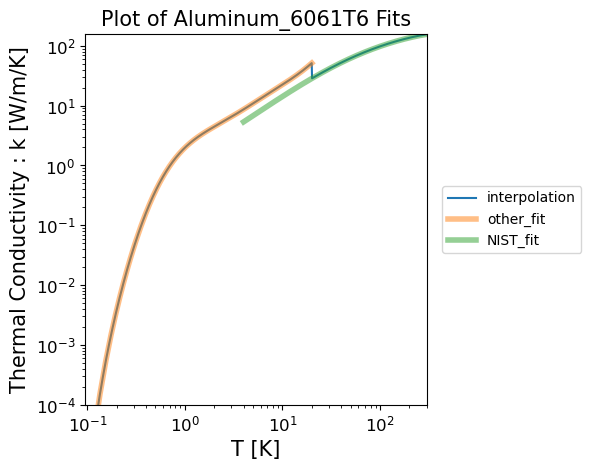

<Figure size 640x480 with 0 Axes>

In [17]:
material = "Aluminum_6061T6"
Al_6061T6_interpolation = interpolate(material)
plot_interpolation(material, Al_6061T6_interpolation, show = True)

Perfect! Now let's test the feature that allows us to choose a preffered fit.

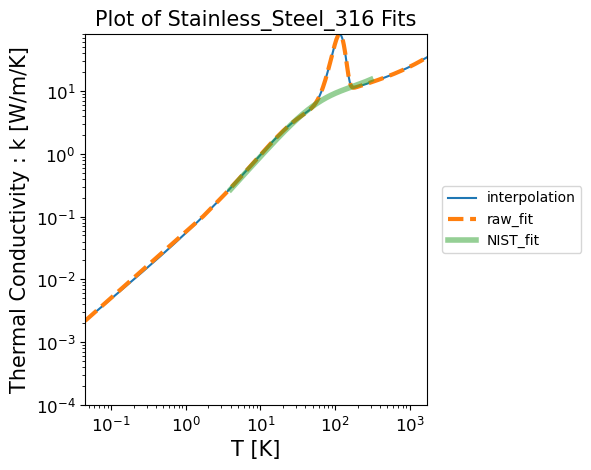

<Figure size 640x480 with 0 Axes>

In [18]:
material = "Stainless_Steel_316"
undesired_interpolation = interpolate(material)
plot_interpolation(material, undesired_interpolation, show = True)

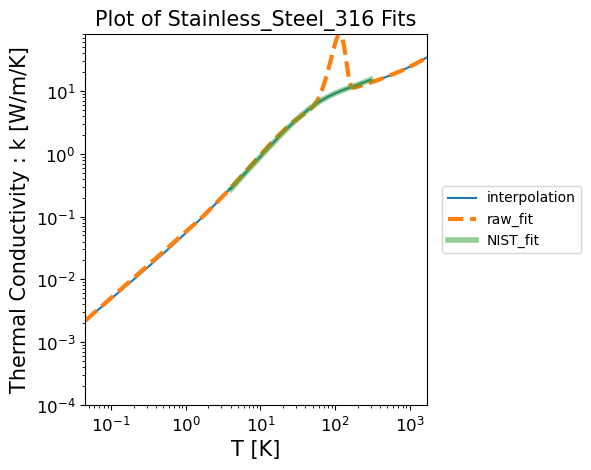

<Figure size 640x480 with 0 Axes>

In [19]:
material = "Stainless_Steel_316"
preferred_interpolation = interpolate(material, preferred_fit = "NIST_fit")
plot_interpolation(material, preferred_interpolation, show = True)

Great! Now, let's see if it reacts properly to our room temperature data file.

[300, 7.74]
<class 'list'>
<class 'float'>


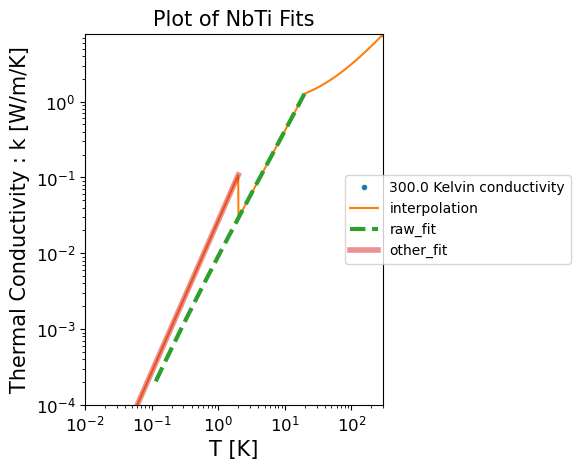

<Figure size 640x480 with 0 Axes>

In [31]:
material = "NbTi"
interpolation_with_room_temp = interpolate(material)
plot_interpolation(material, interpolation_with_room_temp, show = True)

Cool! Now let's check if we can integrate over the interpolation function.

Integral Value: 402.13126866653363


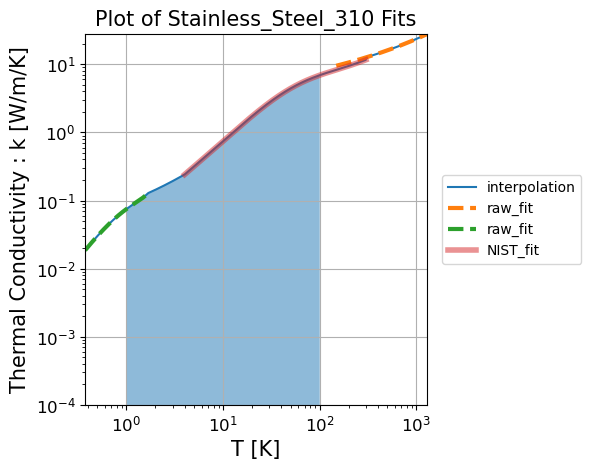

In [160]:
material = "Stainless_Steel_310"
integration_range = [1, 100]

integration_interpolation = interpolate(material)
area, err = integrate.quad(integration_interpolation, *integration_range)
print("Integral Value:", area)

plot_interpolation(material, integration_interpolation)
area_x = np.logspace(np.log10(integration_range[0]), np.log10(integration_range[1]), 100)
area_y = integration_interpolation(area_x)
plt.fill_between(area_x, area_y, alpha = 0.5)

Amazing! Finally, let's generate an interpolation plot of every material in the repository.

In [161]:
all_files = os.listdir(cm_dir)
TC_file = [file for file in all_files if file.startswith("tc_fullrepo")]
TC_file = TC_file[0]

TCdata = np.loadtxt(f"{cm_dir}{os.sep}{TC_file}", dtype=str, delimiter=',') # imports compilation file csv

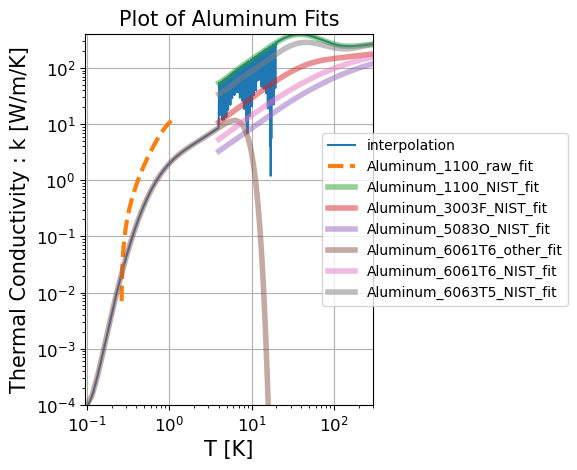

<Figure size 640x480 with 0 Axes>

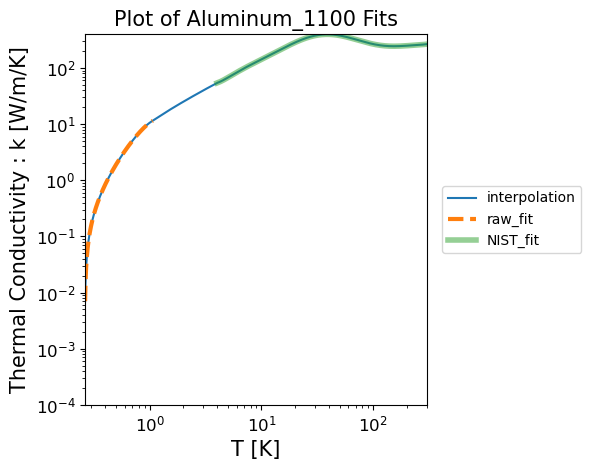

<Figure size 640x480 with 0 Axes>

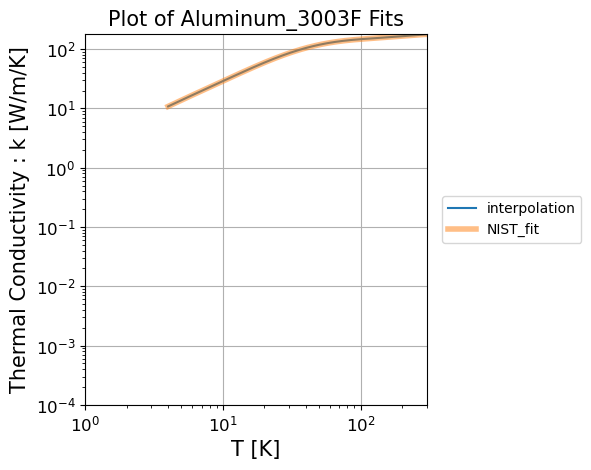

<Figure size 640x480 with 0 Axes>

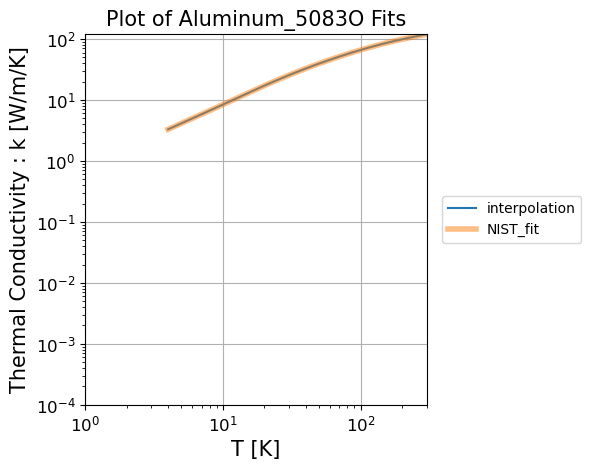

<Figure size 640x480 with 0 Axes>

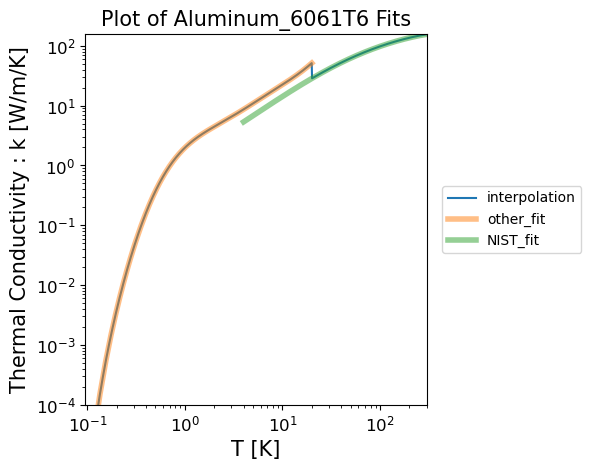

<Figure size 640x480 with 0 Axes>

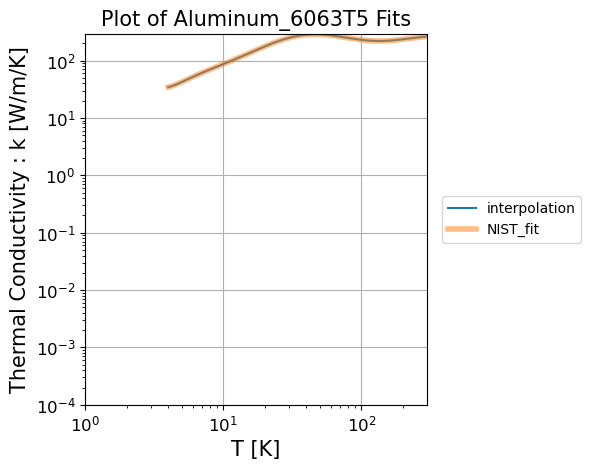

<Figure size 640x480 with 0 Axes>

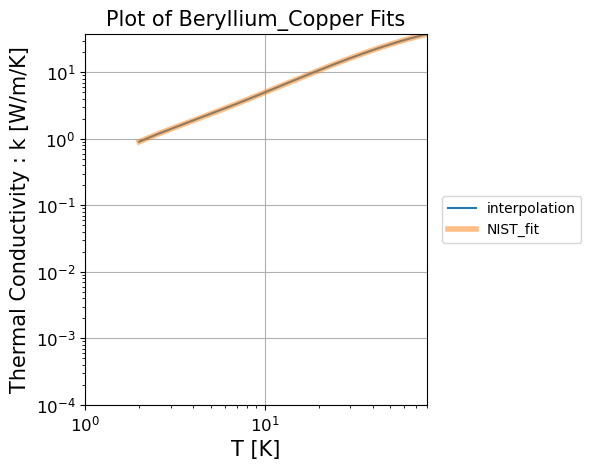

<Figure size 640x480 with 0 Axes>

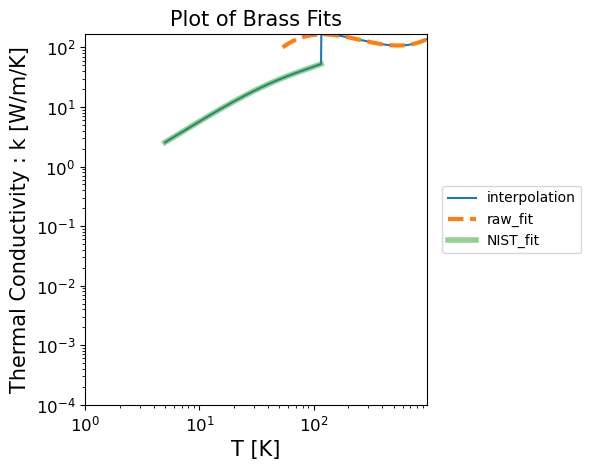

<Figure size 640x480 with 0 Axes>

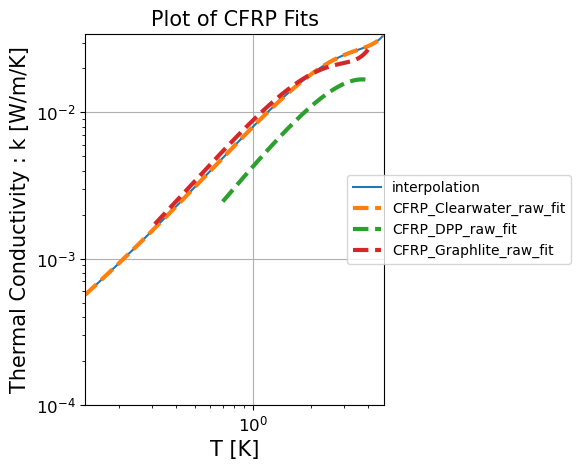

<Figure size 640x480 with 0 Axes>

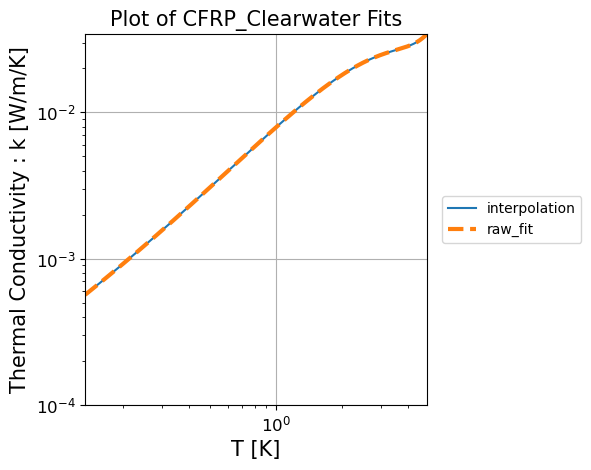

<Figure size 640x480 with 0 Axes>

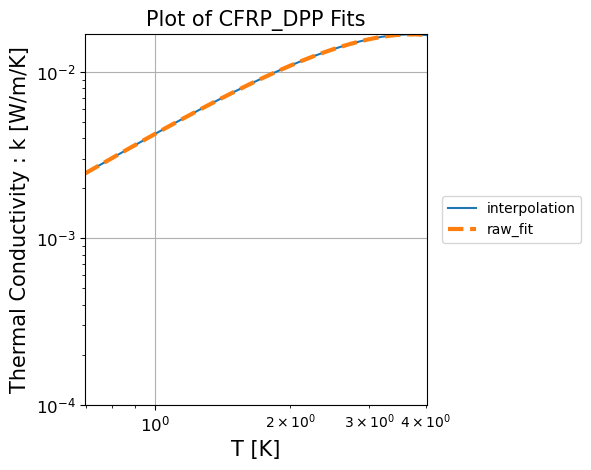

<Figure size 640x480 with 0 Axes>

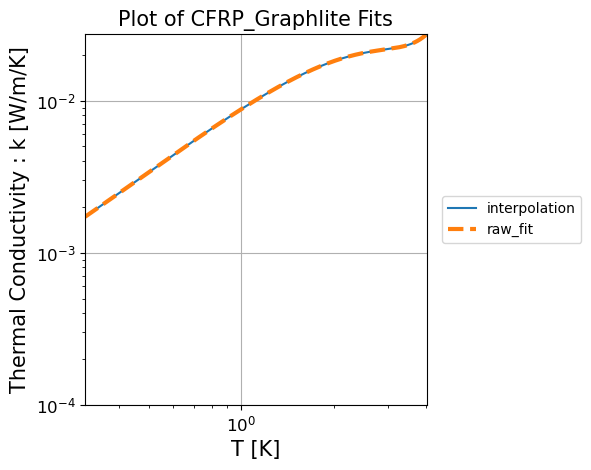

<Figure size 640x480 with 0 Axes>

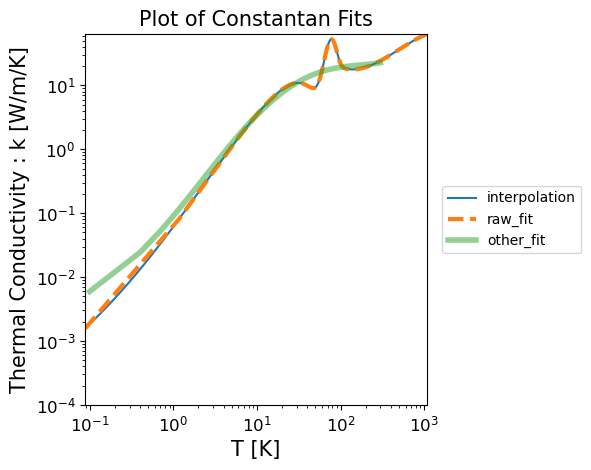

<Figure size 640x480 with 0 Axes>

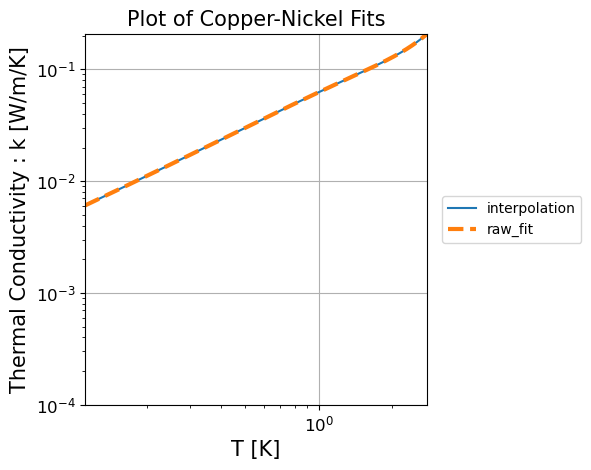

<Figure size 640x480 with 0 Axes>

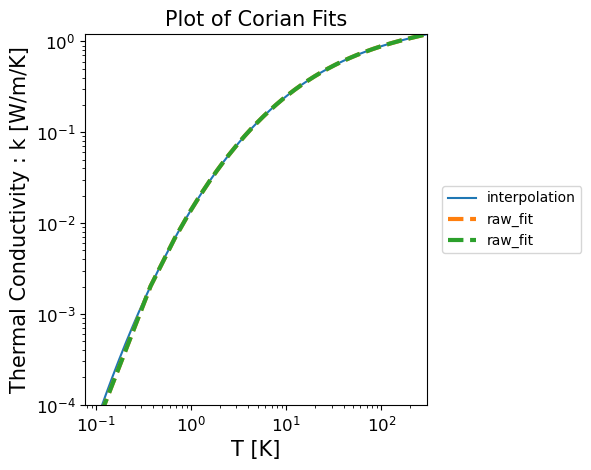

<Figure size 640x480 with 0 Axes>

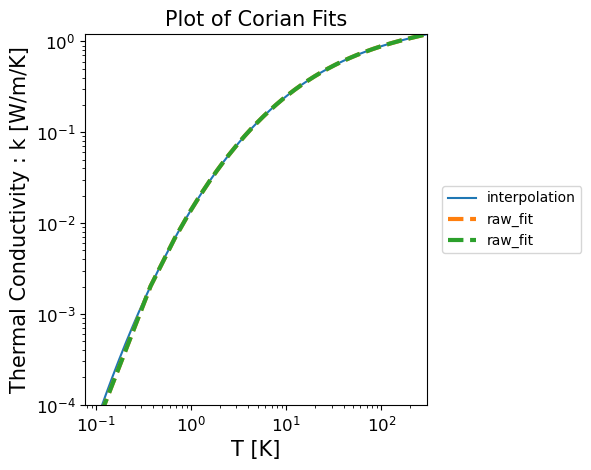

<function OFHC_RRR_Wc at 0x778a0b88aac0> not supported.
Error encountered when evaluating OFHC_RRR_Wc, function type not yet supported. Skipping this fit.


<Figure size 640x480 with 0 Axes>

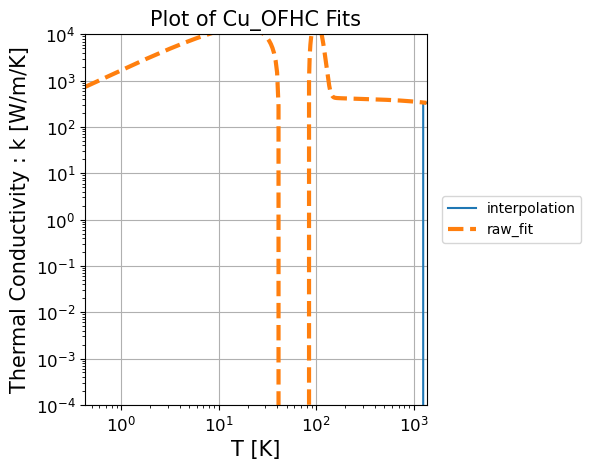

<Figure size 640x480 with 0 Axes>

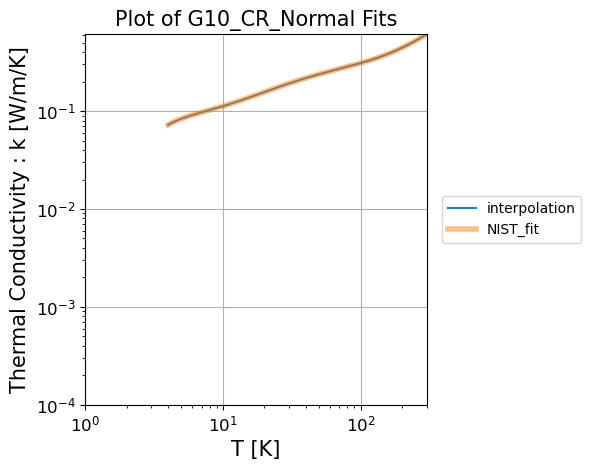

<Figure size 640x480 with 0 Axes>

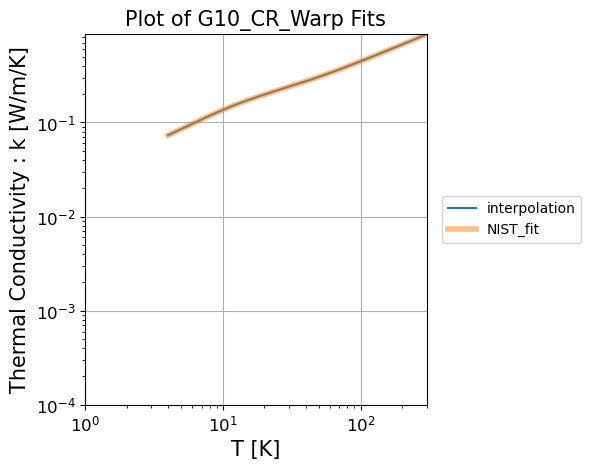

<Figure size 640x480 with 0 Axes>

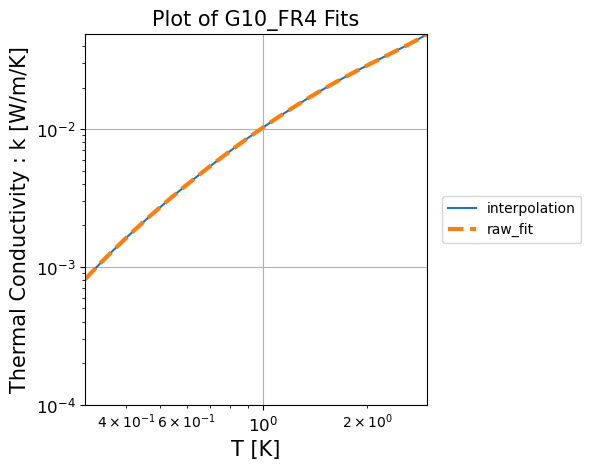

<Figure size 640x480 with 0 Axes>

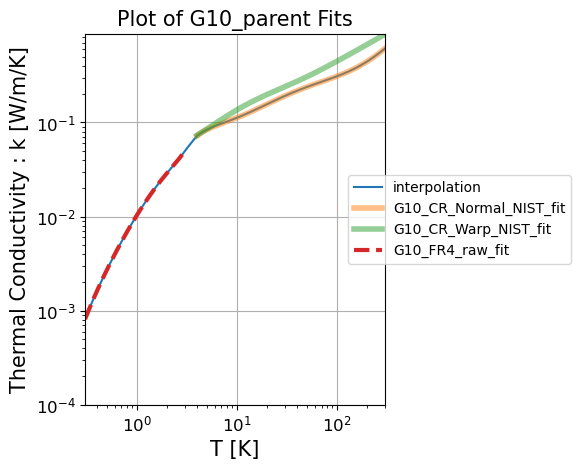

<Figure size 640x480 with 0 Axes>

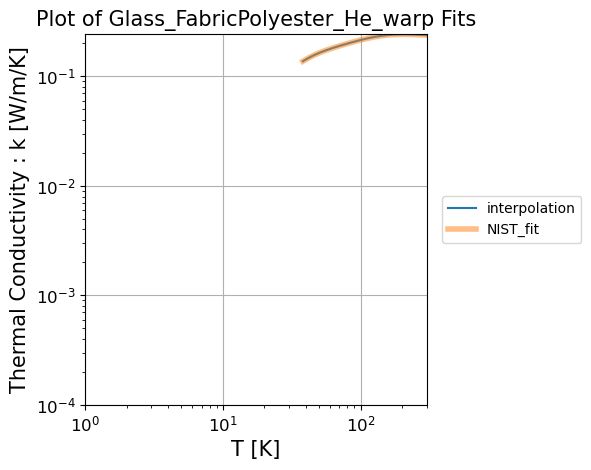

<Figure size 640x480 with 0 Axes>

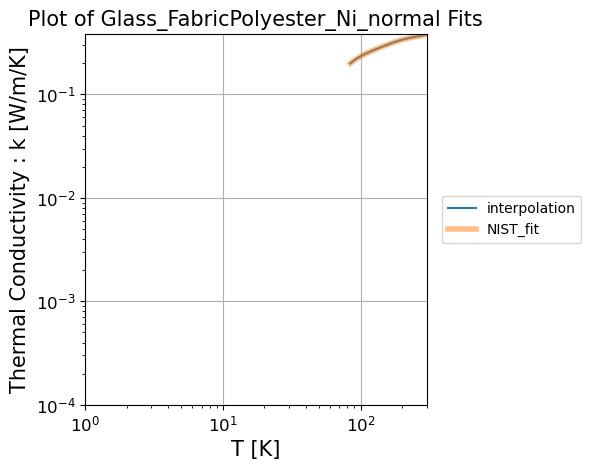

<Figure size 640x480 with 0 Axes>

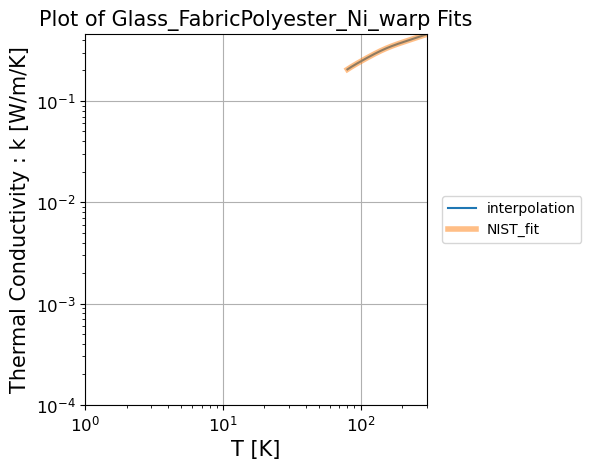

<Figure size 640x480 with 0 Axes>

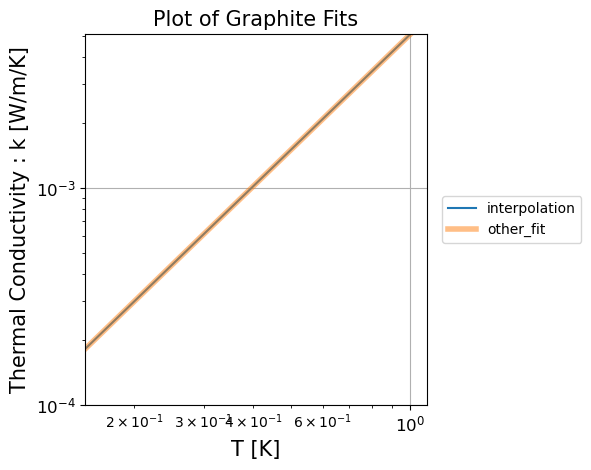

<Figure size 640x480 with 0 Axes>

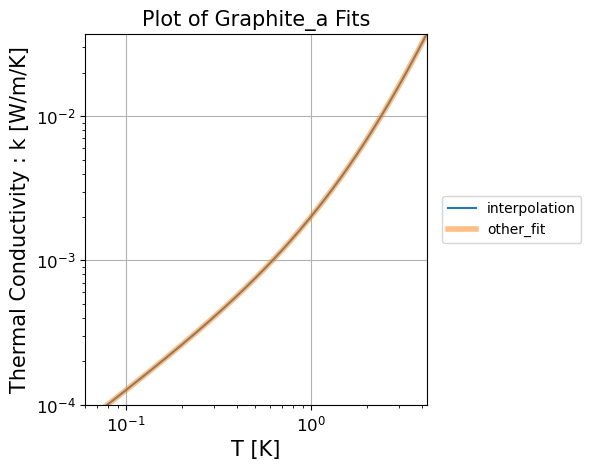

<Figure size 640x480 with 0 Axes>

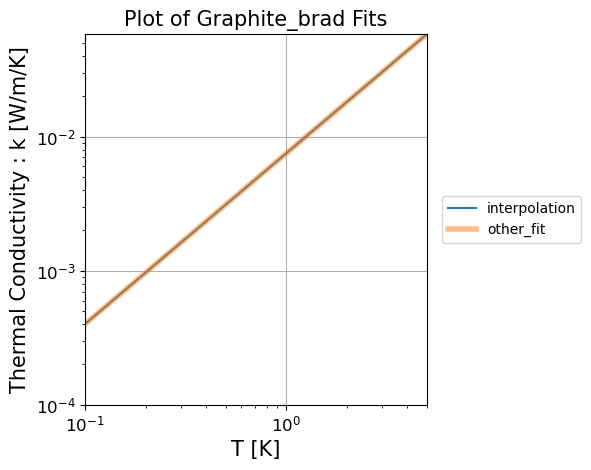

<Figure size 640x480 with 0 Axes>

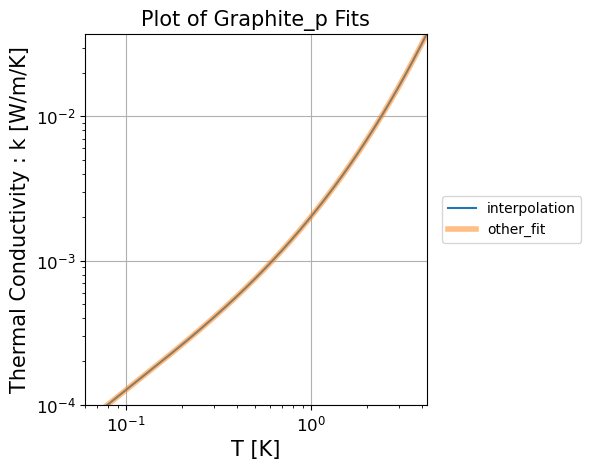

<Figure size 640x480 with 0 Axes>

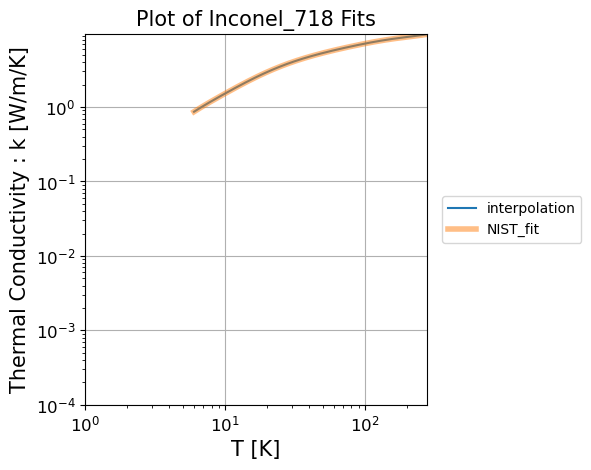

<Figure size 640x480 with 0 Axes>

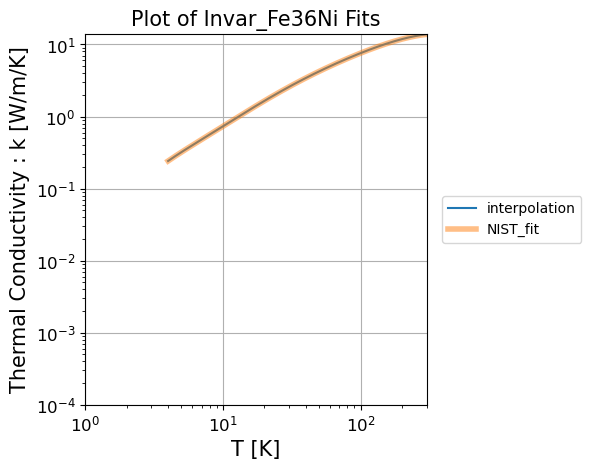

<Figure size 640x480 with 0 Axes>

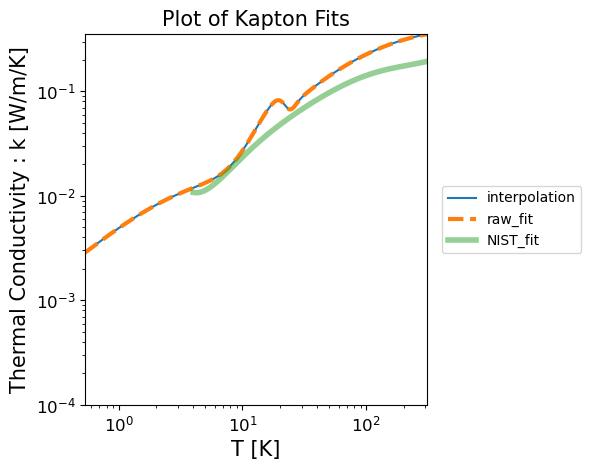

<Figure size 640x480 with 0 Axes>

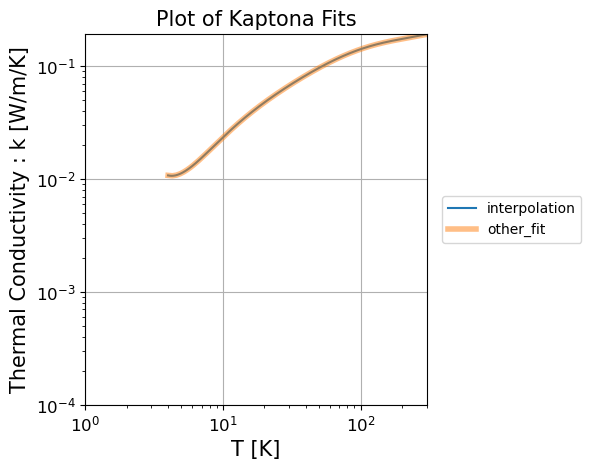

<Figure size 640x480 with 0 Axes>

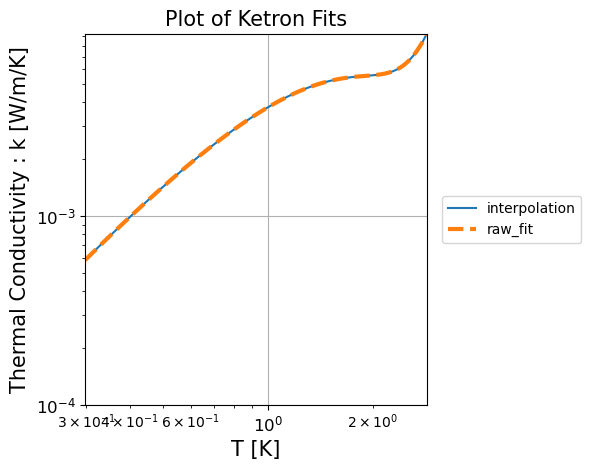

<Figure size 640x480 with 0 Axes>

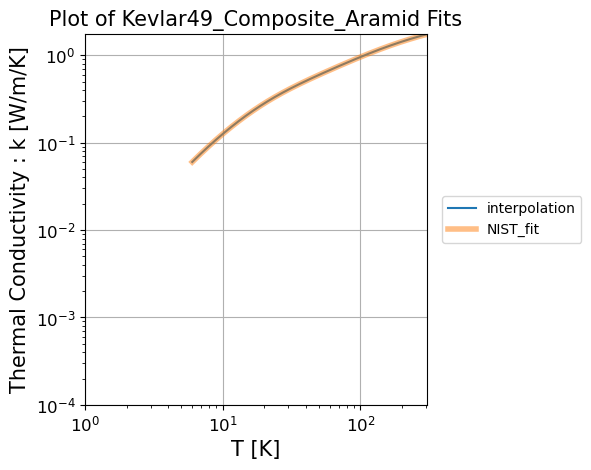

<Figure size 640x480 with 0 Axes>

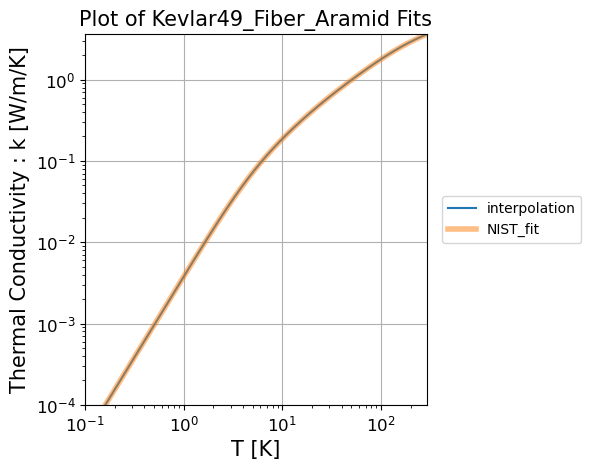

<Figure size 640x480 with 0 Axes>

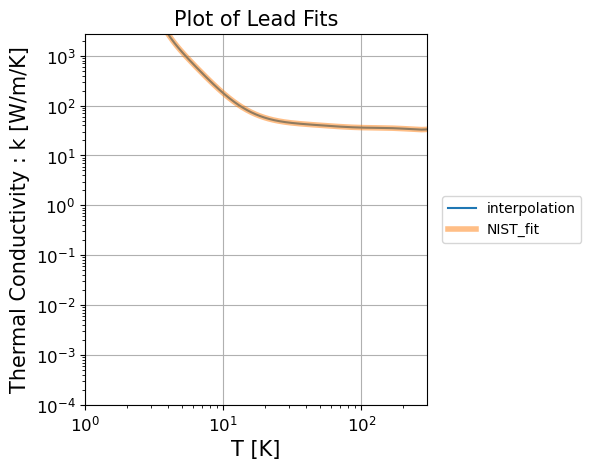

<Figure size 640x480 with 0 Axes>

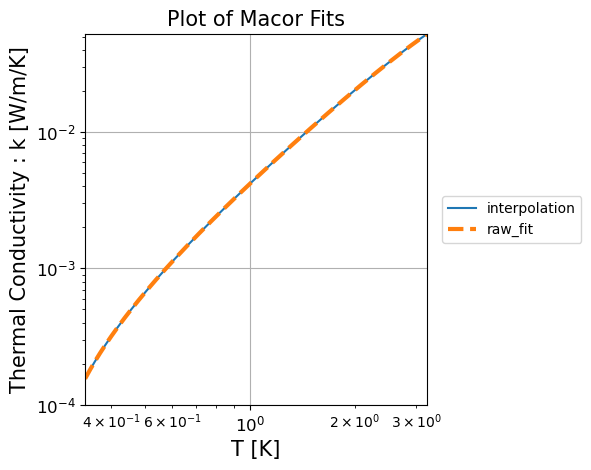

<Figure size 640x480 with 0 Axes>

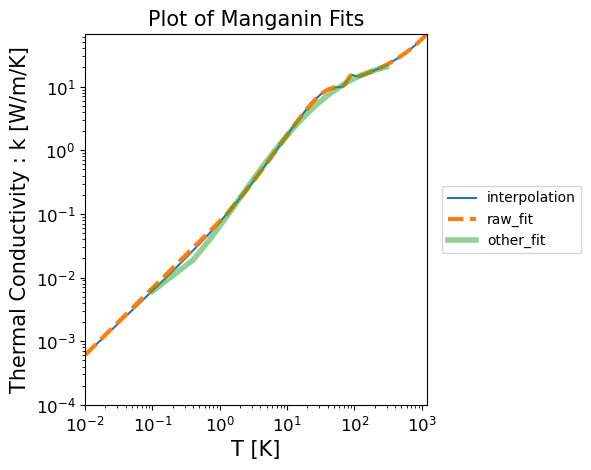

<Figure size 640x480 with 0 Axes>

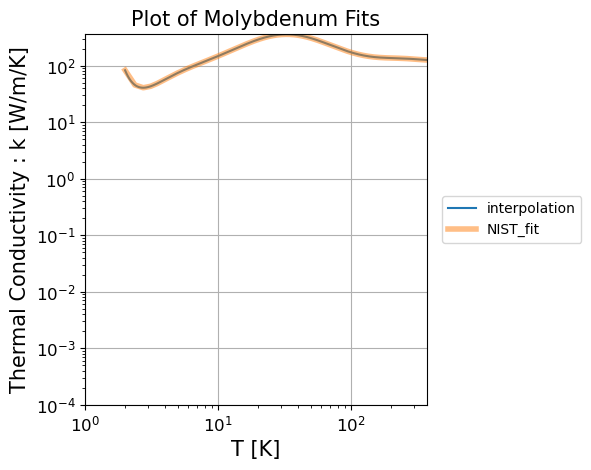

<Figure size 640x480 with 0 Axes>

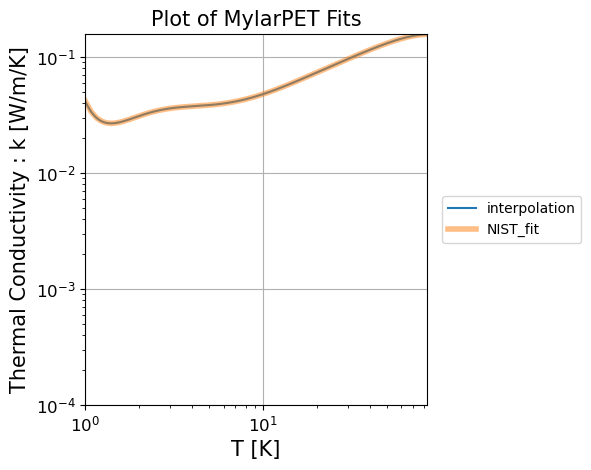

<Figure size 640x480 with 0 Axes>

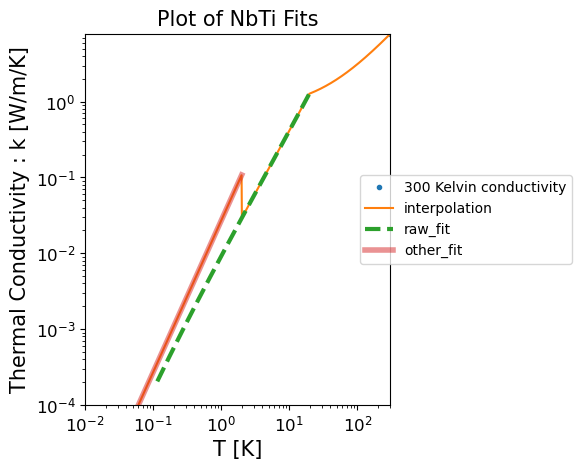

<Figure size 640x480 with 0 Axes>

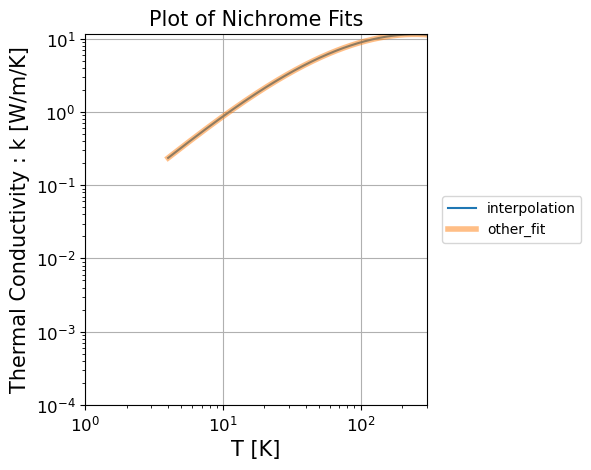

<Figure size 640x480 with 0 Axes>

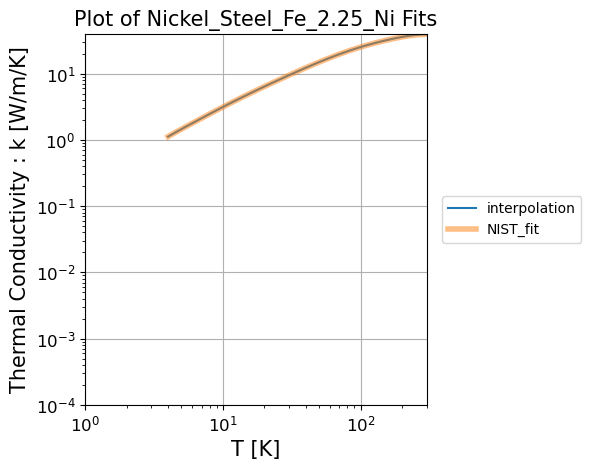

<Figure size 640x480 with 0 Axes>

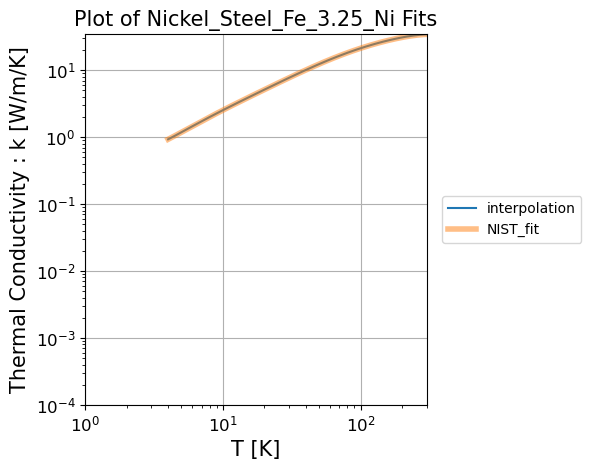

<Figure size 640x480 with 0 Axes>

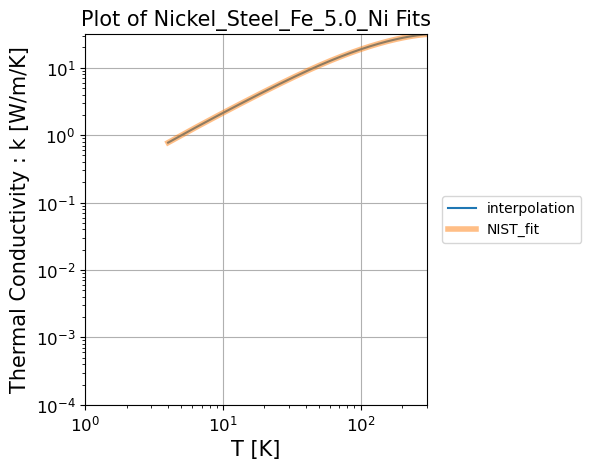

<Figure size 640x480 with 0 Axes>

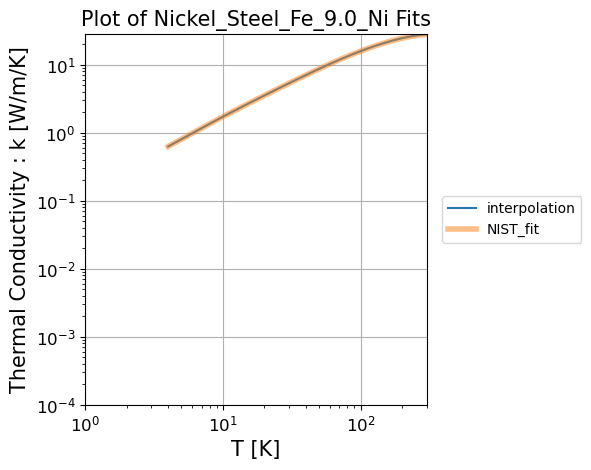

<Figure size 640x480 with 0 Axes>

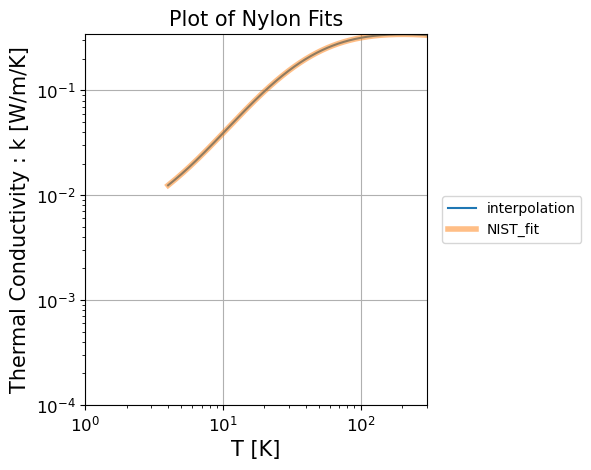

<Figure size 640x480 with 0 Axes>

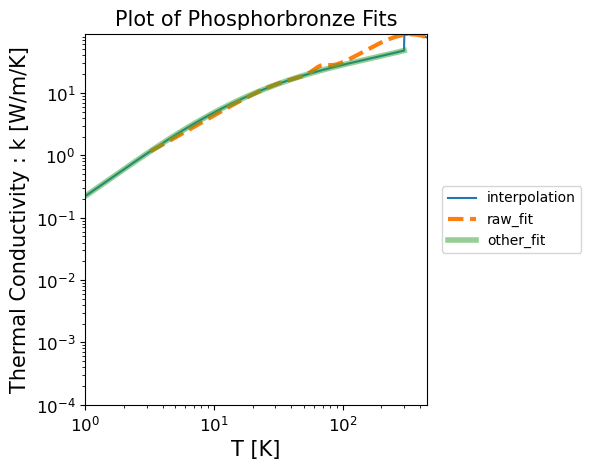

<Figure size 640x480 with 0 Axes>

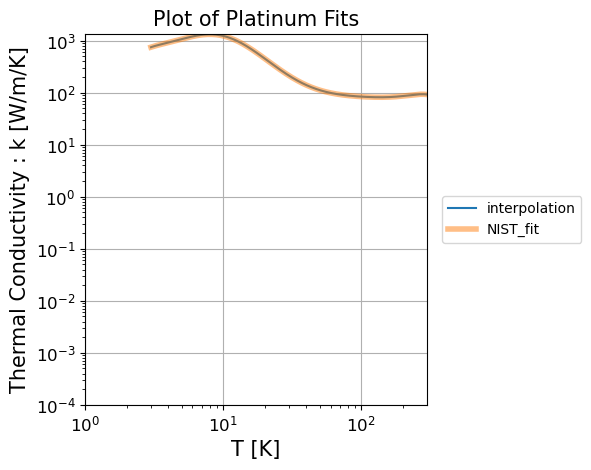

<Figure size 640x480 with 0 Axes>

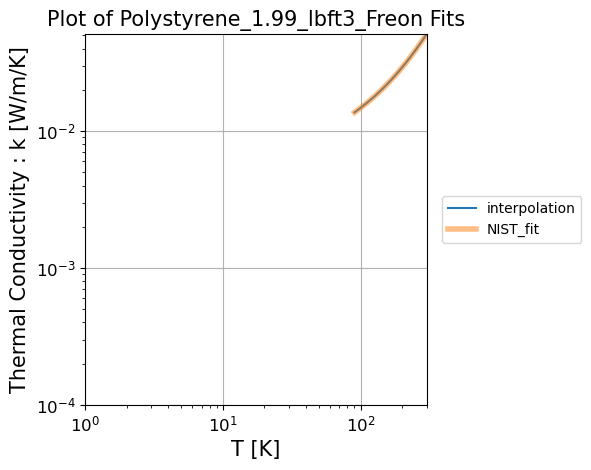

<Figure size 640x480 with 0 Axes>

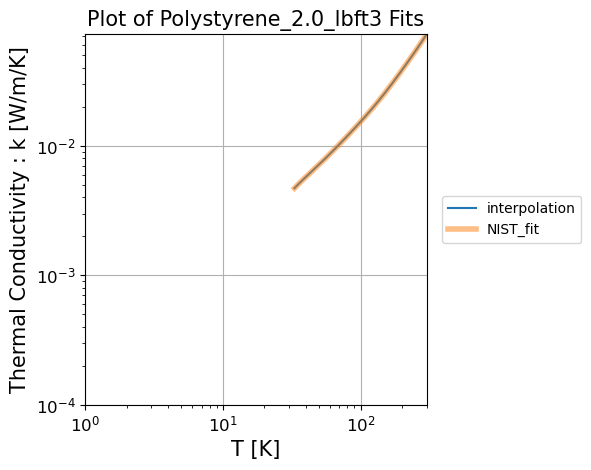

<Figure size 640x480 with 0 Axes>

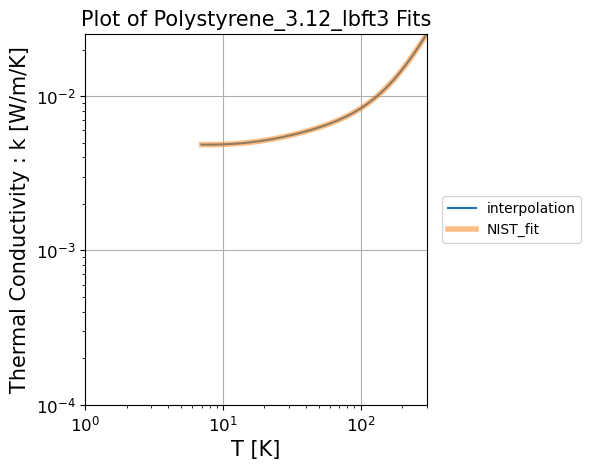

<Figure size 640x480 with 0 Axes>

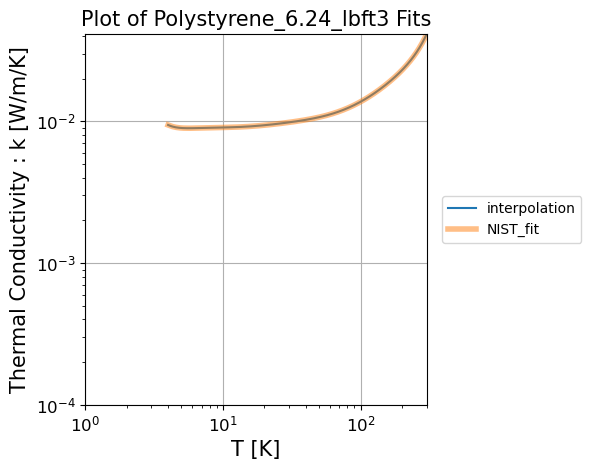

<Figure size 640x480 with 0 Axes>

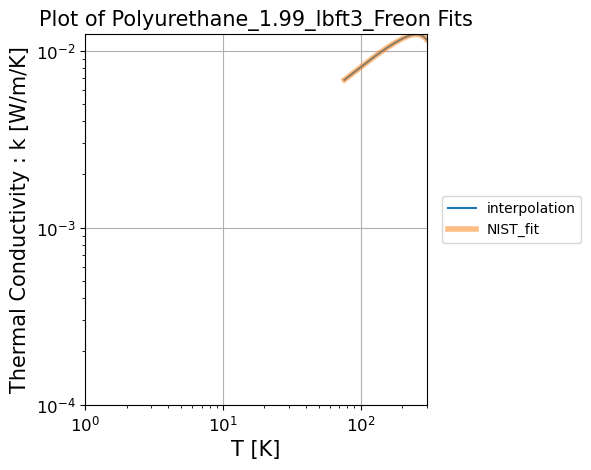

<Figure size 640x480 with 0 Axes>

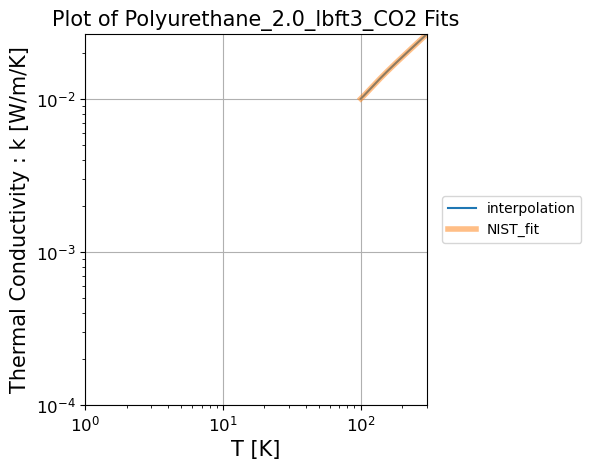

<Figure size 640x480 with 0 Axes>

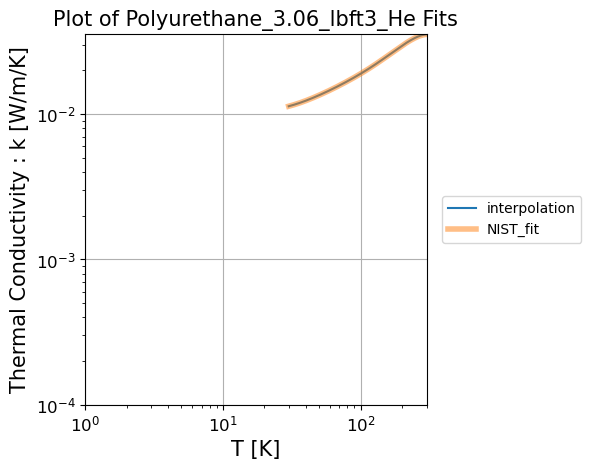

<Figure size 640x480 with 0 Axes>

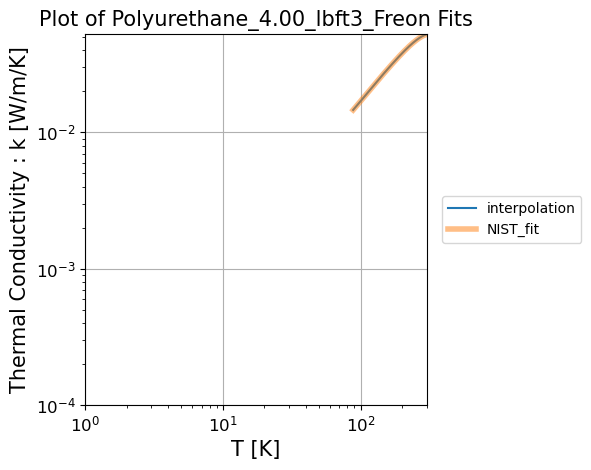

<Figure size 640x480 with 0 Axes>

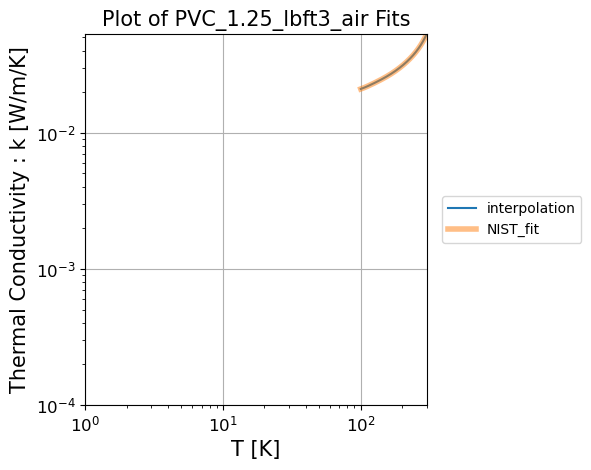

<Figure size 640x480 with 0 Axes>

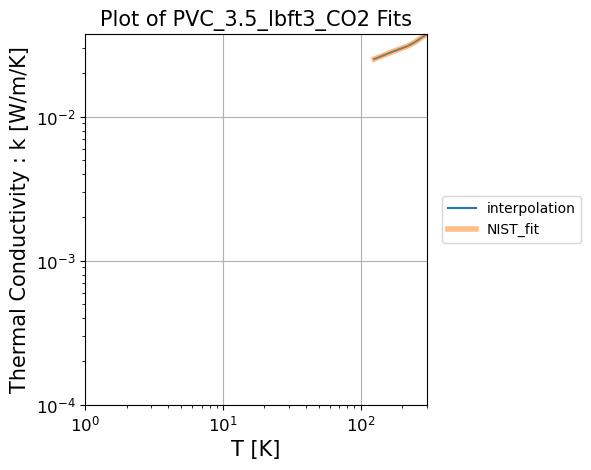

<Figure size 640x480 with 0 Axes>

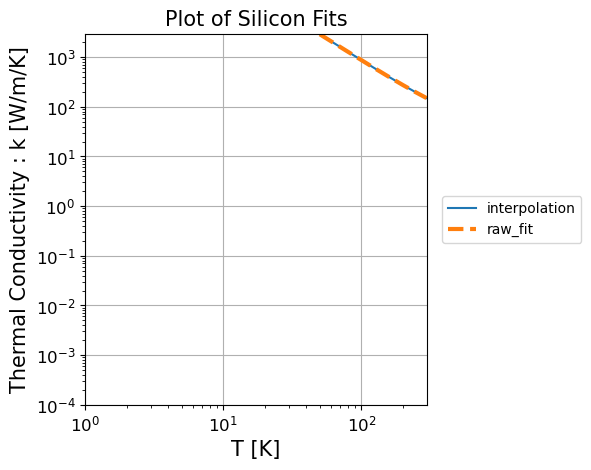

<Figure size 640x480 with 0 Axes>

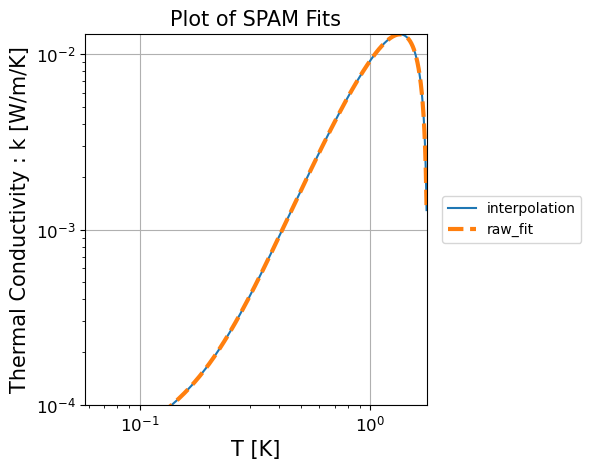

<Figure size 640x480 with 0 Axes>

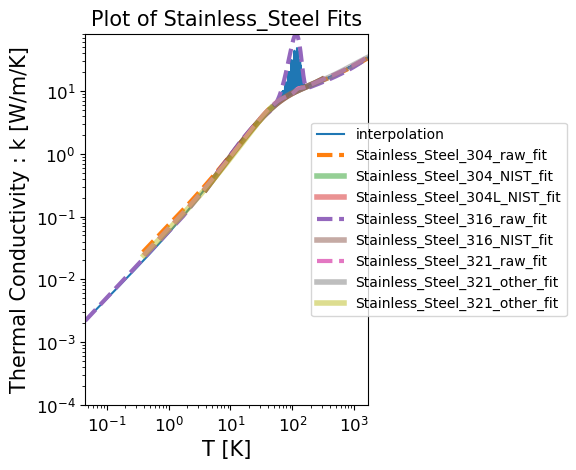

<Figure size 640x480 with 0 Axes>

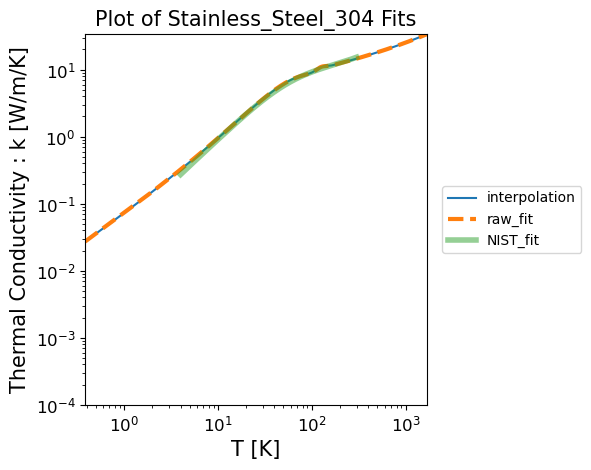

<Figure size 640x480 with 0 Axes>

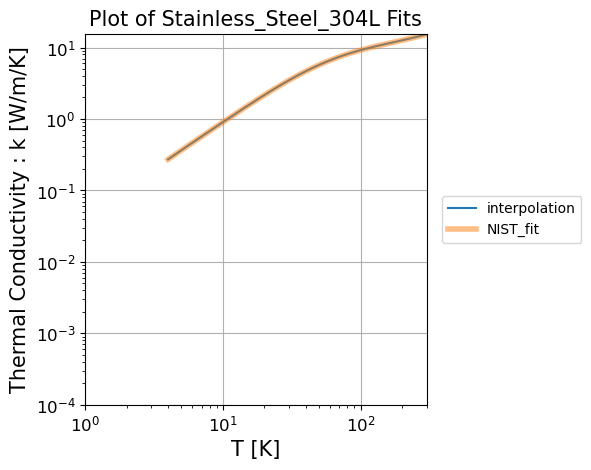

<Figure size 640x480 with 0 Axes>

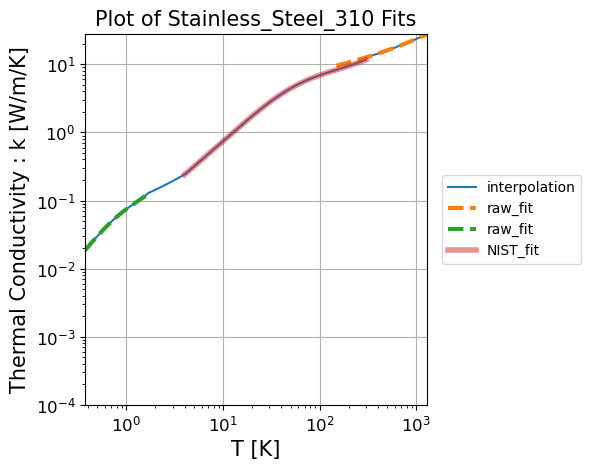

<Figure size 640x480 with 0 Axes>

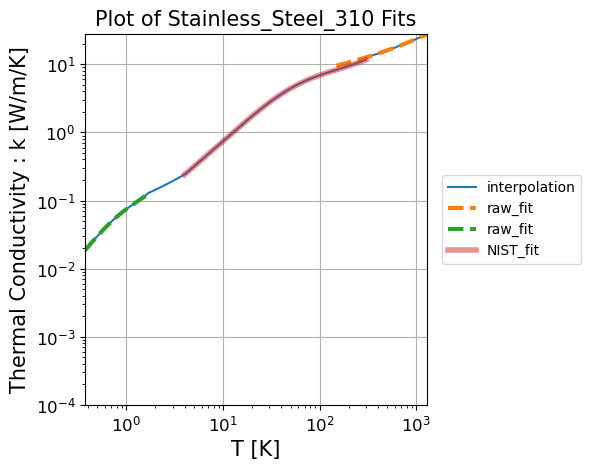

<Figure size 640x480 with 0 Axes>

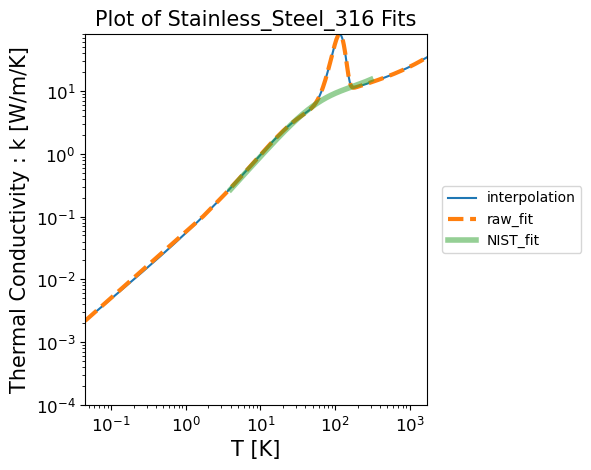

<Figure size 640x480 with 0 Axes>

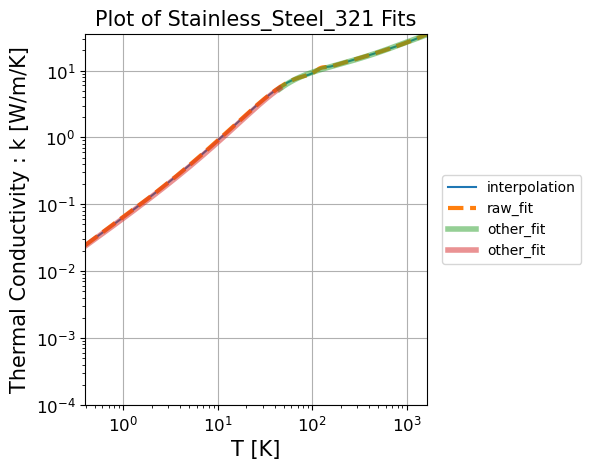

<Figure size 640x480 with 0 Axes>

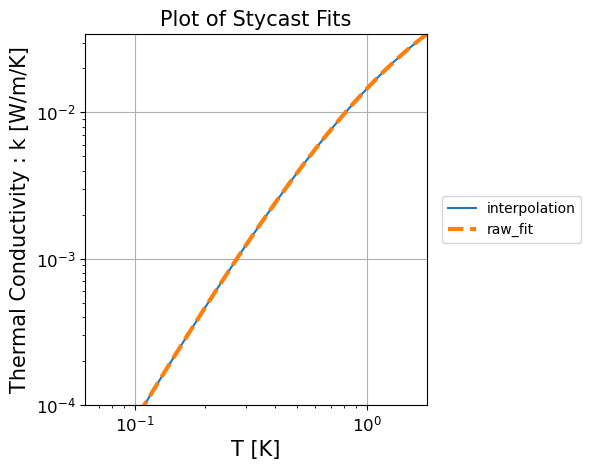

<Figure size 640x480 with 0 Axes>

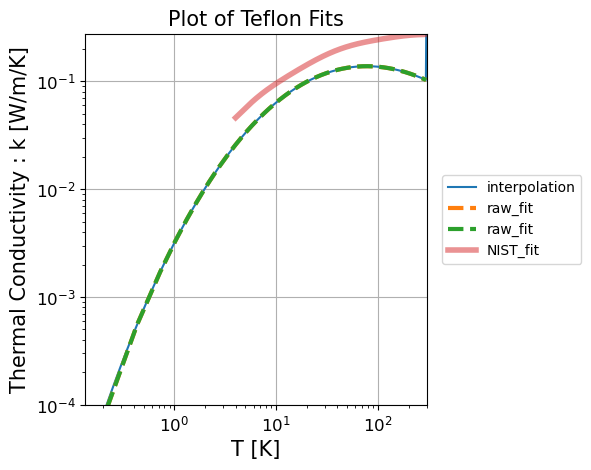

<Figure size 640x480 with 0 Axes>

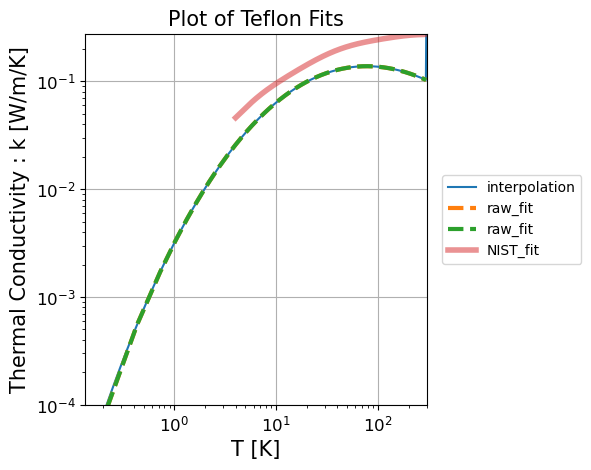

<Figure size 640x480 with 0 Axes>

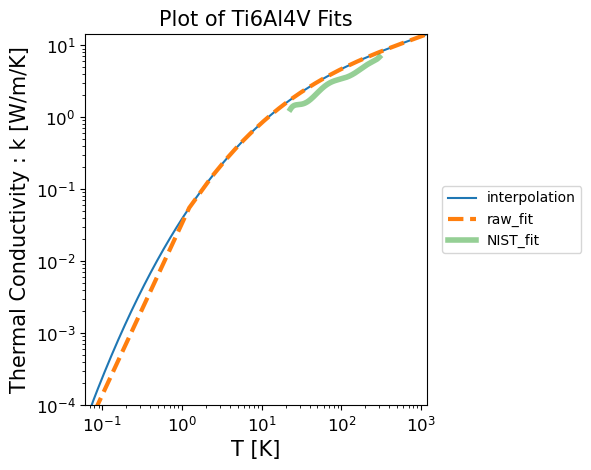

<Figure size 640x480 with 0 Axes>

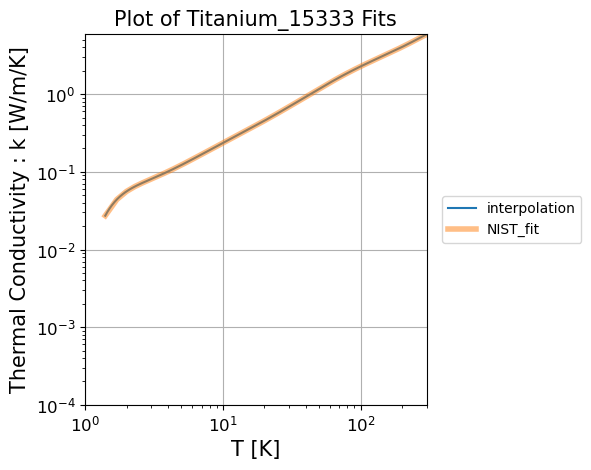

<Figure size 640x480 with 0 Axes>

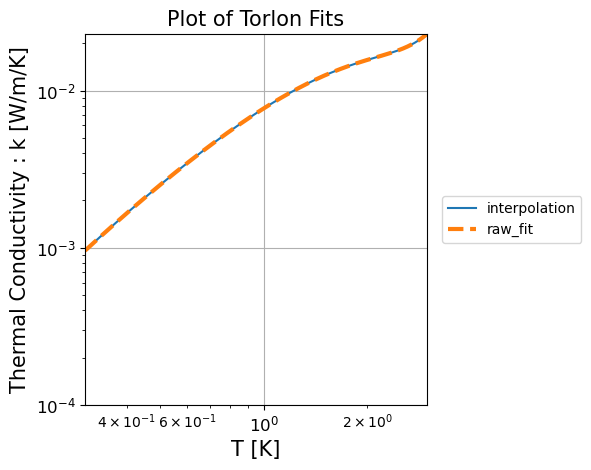

<Figure size 640x480 with 0 Axes>

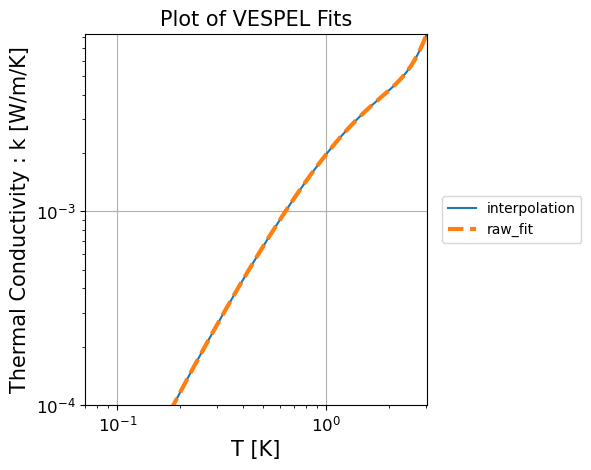

<Figure size 640x480 with 0 Axes>

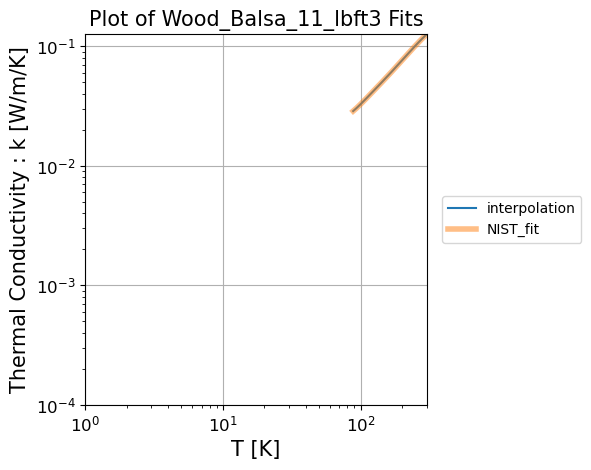

<Figure size 640x480 with 0 Axes>

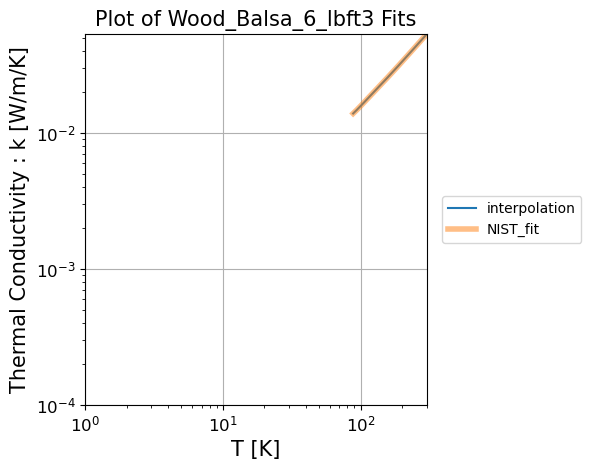

<Figure size 640x480 with 0 Axes>

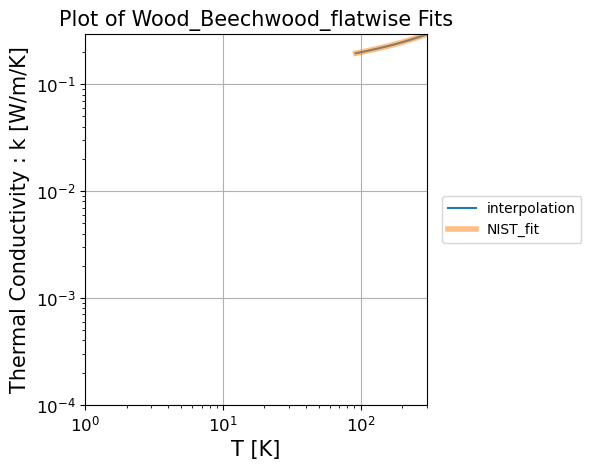

<Figure size 640x480 with 0 Axes>

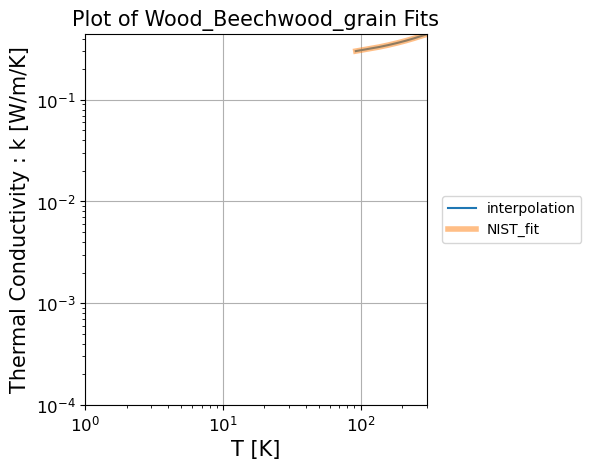

<Figure size 640x480 with 0 Axes>

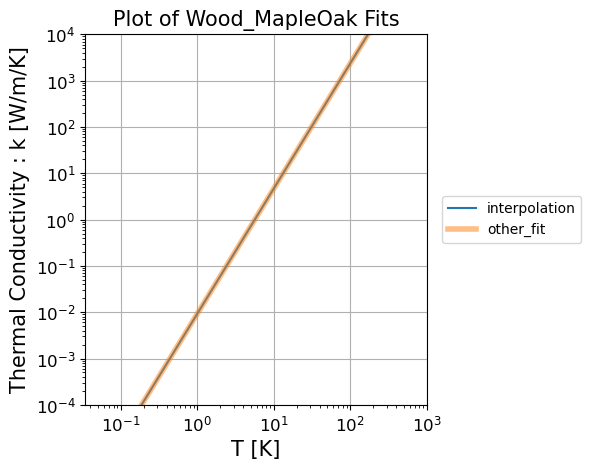

<Figure size 640x480 with 0 Axes>

In [162]:
for material in TCdata[1:, 0]:
    interpolation = interpolate(material)
    plot_interpolation(material, interpolation, show = True)